<a href="https://colab.research.google.com/github/pdrzxzz/knn-from-scratch/blob/main/knn_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# knn_from_scratch.py

# Importing necessary libraries
import time
import sys
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting evaluation metrics
from collections import Counter  # For majority voting in KNN

# Utility functions for splitting the dataset and evaluating model performance
from sklearn.model_selection import train_test_split  # For splitting the dataset
from sklearn.metrics import classification_report  # For model evaluation

# For optional debug logging
import logging

# Datasets to test the algorithm
from sklearn.datasets import load_iris, load_wine, load_digits
from tensorflow.keras.datasets import fashion_mnist

# Define the range of K values to evaluate
K_VALUES = range(3, 16)  # You can increase this if desired


def euclidean_distance(x1, x2):
    """
    Computes the Euclidean distance between two vectors.

    Args:
        x1 (np.ndarray): First input vector.
        x2 (np.ndarray): Second input vector.

    Returns:
        float: Euclidean distance between x1 and x2.
    """
    # np.linalg.norm computes the L2 norm (Euclidean distance) between the two vectors
    return np.linalg.norm(x1 - x2)


def standardize(X):
    """
    Standardizes the feature matrix to have zero mean and unit variance.

    This helps models like KNN that are sensitive to feature scales.

    Args:
        X (np.ndarray): Feature matrix of shape (n_samples, n_features).

    Returns:
        np.ndarray: Standardized feature matrix.
    """
    mean = np.mean(X, axis=0)  # Mean of each feature (column)
    std = np.std(X, axis=0)    # Standard deviation of each feature
    std[std == 0] = 1          # Prevent division by zero if any feature has zero variance
    return (X - mean) / std    # Standardization formula


class KNN:
    """
    K-Nearest Neighbors classifier implementation from scratch.
    """

    def __init__(self, k=3, debug=False):
        """
        Initializes the model.

        Parameters:
        k (int): Number of nearest neighbors to consider. Default is 3.
        debug (bool): If True, enables debug logging. Default is False.
        """
        self.k = k  # Number of neighbors
        self.logger = logging.getLogger('KNN')  # Logger for optional debugging
        self.logger.setLevel(logging.DEBUG if debug else logging.WARNING)
        self.logger.debug(f"\nK value: {self.k}")

    def fit(self, X, y):
        """
        Stores the training data.

        Parameters:
          X (np.ndarray): Training feature matrix of shape (n_samples, n_features).
          y (np.ndarray or list): Target labels corresponding to X.

        Returns:
          None.
        """
        self.X = X  # Save training features
        self.y = y  # Save training labels

    def predict(self, X):
        """
        Predicts the class labels for the provided data.

        Parameters:
          X (np.ndarray): Feature matrix of shape (n_samples, n_features) to predict.

        Returns:
          predictions (list): Predicted class labels for each input sample.
        """
        predictions = []
        counter = 0
        for x in X:
          predictions.append(self._predict(x))
          counter += 1
          print(f"\r{counter}/{len(X)}", end="", flush=True)
        print()
        # self.logger.debug(f"Predictions: {predictions}")
        return predictions  # Predict each sample individually

    def _predict(self, x):
        """
        Predicts the class label for a single sample.

        Parameters:
          x (np.ndarray): Feature vector of a single sample.

        Returns:
          most_common_label (int): Predicted class label.
        """
        # Compute distances from x to all training samples
        distances = [euclidean_distance(x, x_train) for x_train in self.X]
        # self.logger.debug(f"Distances: {distances}")

        # Get indices of the k nearest neighbors (smallest distances)
        k_indices = np.argsort(distances)[:self.k]  # np.argsort returns indices that would sort the array
        # self.logger.debug(f"Indices of {self.k} nearest neighbors: {k_indices}")

        k_nearest_neighbors = [self.X[i] for i in k_indices]
        # self.logger.debug(f"Values of {self.k} nearest neighbors: {k_nearest_neighbors}")

        # Get the labels of those k neighbors
        k_nearest_labels = [self.y[i] for i in k_indices]
        # self.logger.debug(f"Classes of {self.k} nearest neighbors: {k_nearest_labels}")

        most_common_label = Counter(k_nearest_labels).most_common(1)[0][0] # .most_common(1) returns a list like [(label, count)]
        # self.logger.debug(f"Prediction: {most_common_label}")

        # Return the most common label among the k neighbors
        return most_common_label

def evaluate_knn_on_dataset(X, y, dataset_name='dataset', k_values=K_VALUES, debug=False):
    """
    Evaluates the KNN model on a given dataset for multiple K values and plots the results.

    Args:
        X (np.ndarray): Feature matrix.
        y (np.ndarray): Target labels.
        dataset_name (str): Name of the dataset (used for plot titles).
        k_values (iterable): List or range of K values to test.
    """
    # Standardize features (important for distance-based models)
    X = standardize(X)

    # Split data into training and testing sets (70% train, 30% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize dictionary to store metrics for each k value
    metrics = {
        "train": {"accuracy": [], "precision": [], "recall": [], "f1": []},
        "test":  {"accuracy": [], "precision": [], "recall": [], "f1": []}
    }

    # Loop over each value of k
    for k in k_values:
        knn = KNN(k=k, debug=debug)
        knn.fit(X_train, y_train)

        # Predict and store metrics for both train and test sets
        for split, X_data, y_true in [("train", X_train, y_train), ("test", X_test, y_test)]:
            print(f"Predicting on {split.capitalize()}ing data")
            y_pred = knn.predict(X_data)

            # classification_report returns a dictionary with all metrics
            report = classification_report(y_true, y_pred, output_dict=True)

            # Store the relevant weighted-average metrics
            metrics[split]["accuracy"].append(report["accuracy"])
            metrics[split]["precision"].append(report["weighted avg"]["precision"])
            metrics[split]["recall"].append(report["weighted avg"]["recall"])
            metrics[split]["f1"].append(report["weighted avg"]["f1-score"])

    # Plotting performance metrics for each metric type
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))  # Creates a 2x2 grid of subplots

    for ax, metric in zip(axs.flat, ['accuracy', 'precision', 'recall', 'f1']):
        # Plot train and test metric curves
        ax.plot(k_values, metrics['train'][metric], label="Train", marker='o')
        ax.plot(k_values, metrics['test'][metric], label="Test", marker='s')
        ax.set_title(f"{metric.capitalize()} on {dataset_name} dataset", pad=10)
        ax.set_xlabel("K (Number of Neighbors)")
        ax.set_ylabel(metric.capitalize())
        ax.set_xticks(k_values)
        ax.grid(True)
        ax.legend()

    # Improve spacing between plots
    plt.tight_layout()
    plt.show()

DEBUG:KNN:K value: 3


Predicting on Training data
105/105
Predicting on Testing data
45/45


DEBUG:KNN:K value: 4


Predicting on Training data
105/105
Predicting on Testing data
45/45


DEBUG:KNN:K value: 5


Predicting on Training data
105/105
Predicting on Testing data
45/45


DEBUG:KNN:K value: 6


Predicting on Training data
105/105
Predicting on Testing data
45/45


DEBUG:KNN:K value: 7


Predicting on Training data
105/105
Predicting on Testing data
45/45


DEBUG:KNN:K value: 8


Predicting on Training data
105/105
Predicting on Testing data
45/45


DEBUG:KNN:K value: 9


Predicting on Training data
105/105
Predicting on Testing data
45/45


DEBUG:KNN:K value: 10


Predicting on Training data
105/105
Predicting on Testing data
45/45


DEBUG:KNN:K value: 11


Predicting on Training data
105/105
Predicting on Testing data
45/45


DEBUG:KNN:K value: 12


Predicting on Training data
105/105
Predicting on Testing data
45/45


DEBUG:KNN:K value: 13


Predicting on Training data
105/105
Predicting on Testing data
45/45


DEBUG:KNN:K value: 14


Predicting on Training data
105/105
Predicting on Testing data
45/45


DEBUG:KNN:K value: 15


Predicting on Training data
105/105
Predicting on Testing data
45/45


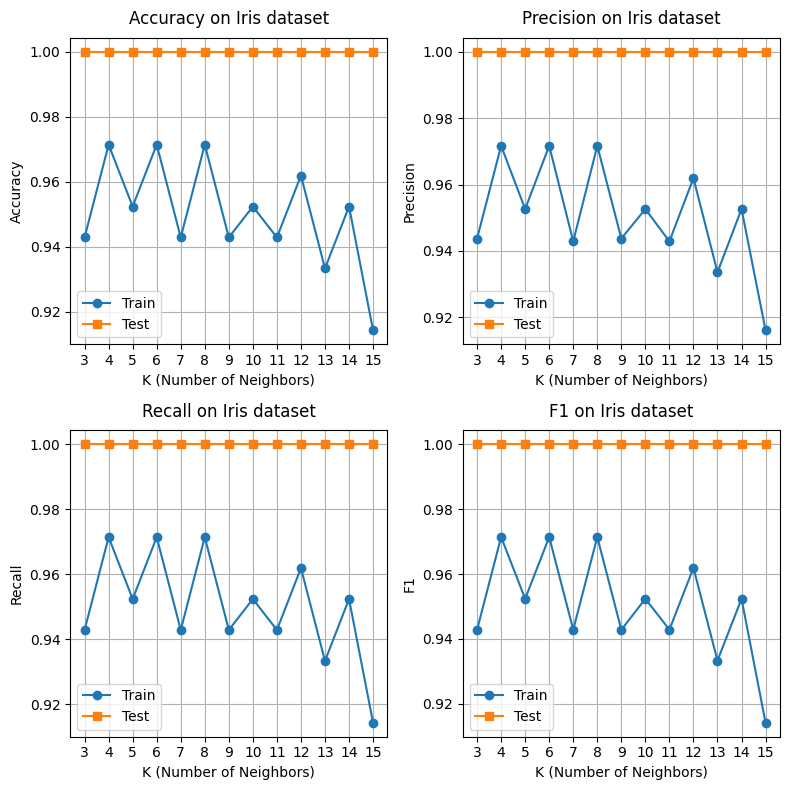

DEBUG:KNN:K value: 3


Predicting on Training data
124/124
Predicting on Testing data
54/54


DEBUG:KNN:K value: 4


Predicting on Training data
124/124
Predicting on Testing data
54/54


DEBUG:KNN:K value: 5


Predicting on Training data
124/124
Predicting on Testing data
54/54


DEBUG:KNN:K value: 6


Predicting on Training data
124/124
Predicting on Testing data
54/54


DEBUG:KNN:K value: 7


Predicting on Training data
124/124
Predicting on Testing data
54/54


DEBUG:KNN:K value: 8


Predicting on Training data
124/124
Predicting on Testing data
54/54


DEBUG:KNN:K value: 9


Predicting on Training data
124/124
Predicting on Testing data
54/54


DEBUG:KNN:K value: 10


Predicting on Training data
124/124
Predicting on Testing data
54/54


DEBUG:KNN:K value: 11


Predicting on Training data
124/124
Predicting on Testing data
54/54


DEBUG:KNN:K value: 12


Predicting on Training data
124/124
Predicting on Testing data
54/54


DEBUG:KNN:K value: 13


Predicting on Training data
124/124
Predicting on Testing data
54/54


DEBUG:KNN:K value: 14


Predicting on Training data
124/124
Predicting on Testing data
54/54


DEBUG:KNN:K value: 15


Predicting on Training data
124/124
Predicting on Testing data
54/54


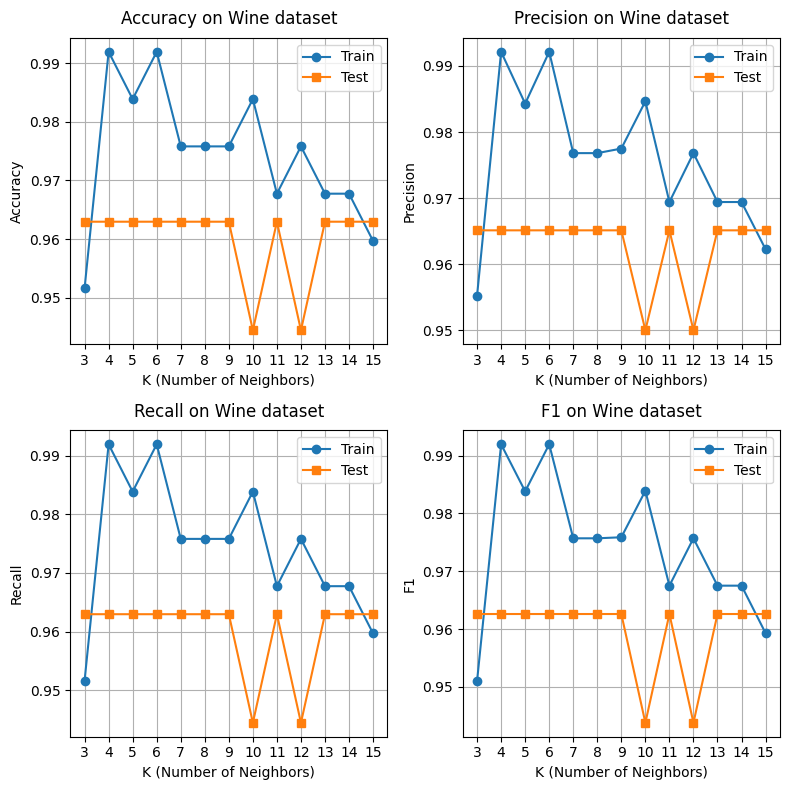

DEBUG:KNN:K value: 3


Predicting on Training data
1257/1257
Predicting on Testing data
540/540


DEBUG:KNN:K value: 4


Predicting on Training data
1257/1257
Predicting on Testing data
540/540


DEBUG:KNN:K value: 5


Predicting on Training data
1257/1257
Predicting on Testing data
540/540


DEBUG:KNN:K value: 6


Predicting on Training data
1257/1257
Predicting on Testing data
540/540


DEBUG:KNN:K value: 7


Predicting on Training data
1257/1257
Predicting on Testing data
540/540


DEBUG:KNN:K value: 8


Predicting on Training data
1257/1257
Predicting on Testing data
540/540


DEBUG:KNN:K value: 9


Predicting on Training data
1257/1257
Predicting on Testing data
540/540


DEBUG:KNN:K value: 10


Predicting on Training data
1257/1257
Predicting on Testing data
540/540

DEBUG:KNN:K value: 11



Predicting on Training data
1257/1257
Predicting on Testing data
540/540


DEBUG:KNN:K value: 12


Predicting on Training data
1257/1257
Predicting on Testing data
540/540


DEBUG:KNN:K value: 13


Predicting on Training data
1257/1257
Predicting on Testing data
540/540


DEBUG:KNN:K value: 14


Predicting on Training data
1257/1257
Predicting on Testing data
540/540


DEBUG:KNN:K value: 15


Predicting on Training data
1257/1257
Predicting on Testing data
540/540


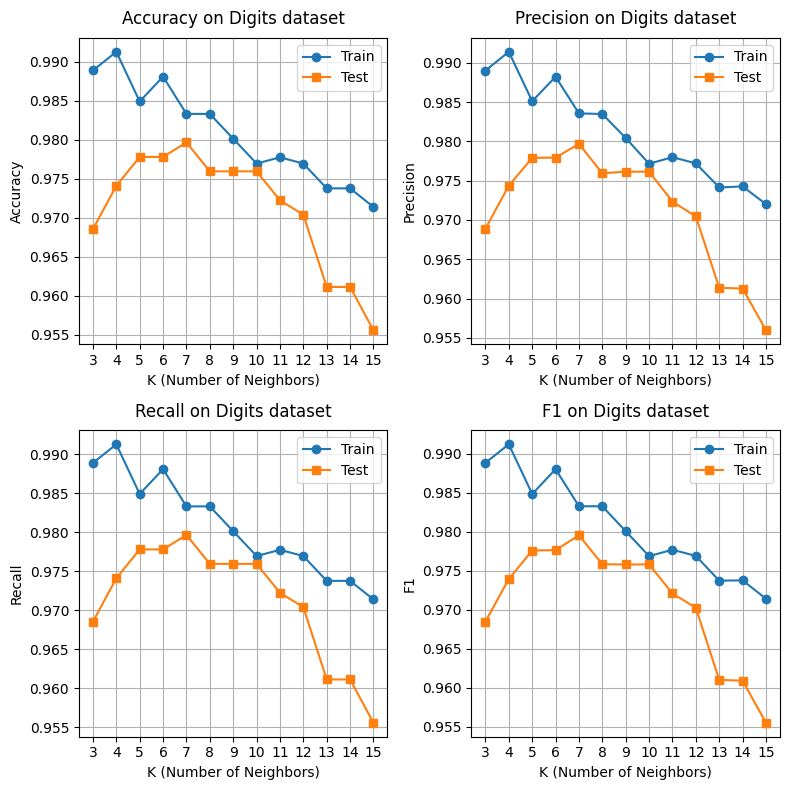

In [ ]:
# Load datasets from sklearn
datasets = {
    'Iris': load_iris(),     # Simple dataset with 3 classes
    'Wine': load_wine(),     # 3-class dataset with 13 features
    'Digits': load_digits(),  # 10-class dataset of handwritten digits (images flattened to 64 features)
}

# Run evaluation loop for each sklearn dataset
for name, data in datasets.items():
    X, y = data.data, data.target  # Separate features and labels
    evaluate_knn_on_dataset(X, y, dataset_name=name, debug=True)  # Run the evaluation

DEBUG:KNN:K value: 3


Predicting on Training data
4900/4900
Predicting on Testing data
2100/2100

DEBUG:KNN:K value: 4



Predicting on Training data
4900/4900
Predicting on Testing data
2100/2100

DEBUG:KNN:K value: 5



Predicting on Training data
4900/4900
Predicting on Testing data
2100/2100

DEBUG:KNN:K value: 6



Predicting on Training data
4900/4900
Predicting on Testing data
2100/2100

DEBUG:KNN:K value: 7



Predicting on Training data
4900/4900
Predicting on Testing data
2100/2100

DEBUG:KNN:K value: 8



Predicting on Training data
4900/4900
Predicting on Testing data
2100/2100


DEBUG:KNN:K value: 9


Predicting on Training data
4900/4900
Predicting on Testing data
2100/2100


DEBUG:KNN:K value: 10


Predicting on Training data
4900/4900
Predicting on Testing data
2100/2100

DEBUG:KNN:K value: 11



Predicting on Training data
4900/4900
Predicting on Testing data
2100/2100

DEBUG:KNN:K value: 12



Predicting on Training data
4900/4900
Predicting on Testing data
2100/2100


DEBUG:KNN:K value: 13


Predicting on Training data
4900/4900
Predicting on Testing data
2100/2100


DEBUG:KNN:K value: 14


Predicting on Training data
4900/4900
Predicting on Testing data
2100/2100

DEBUG:KNN:K value: 15



Predicting on Training data
4900/4900
Predicting on Testing data
2100/2100


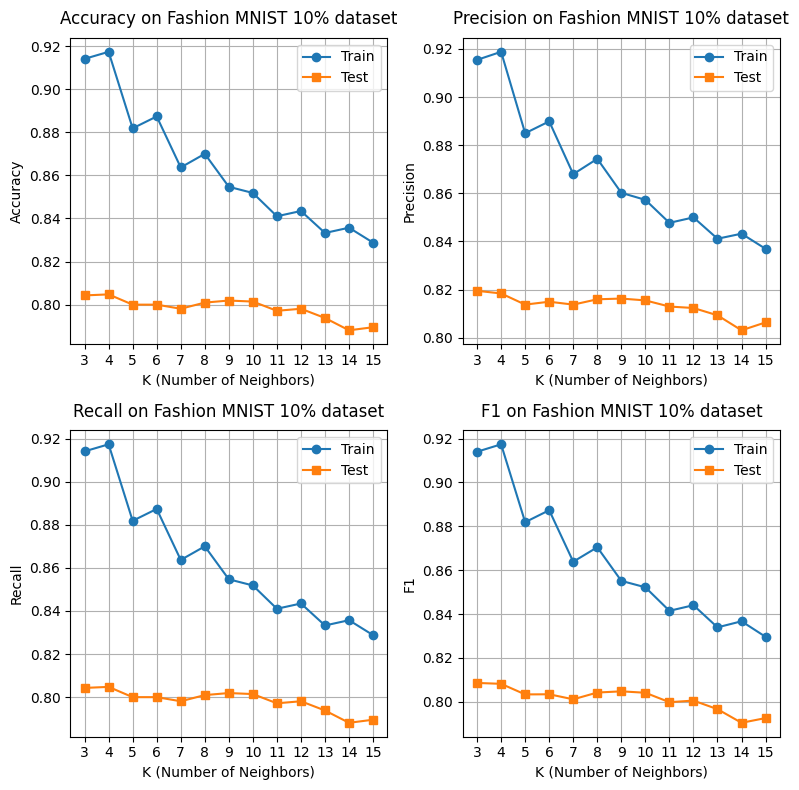

Execution time: 2264.24 seconds


In [4]:
start_time = time.time()

# Load dataset from tensorflow
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

assert X_train.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)
X = np.concatenate([X_train, X_test], axis=0)  # shape: (70000, 28, 28)
y = np.concatenate([y_train, y_test], axis=0)  # shape: (70000,)

# Generates random indices
sample_size_percent = 10#% of the total X
sample_size = int(sample_size_percent/100 * len(X))
indices = np.random.choice(len(X), size=sample_size, replace=False)

# Take the sample
X = X[indices]
y = y[indices]

X = X.reshape((X.shape[0], -1))  # Convert (a, b, c) → (a, b*c)

evaluate_knn_on_dataset(X, y, dataset_name=f'Fashion MNIST {sample_size_percent}%', debug=True)

end_time = time.time()
execution_time = end_time - start_time

print(f'Execution time: {execution_time:.2f} seconds')